In [1]:
# EDA and preprocessing
import re
import spacy
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# plotting data
import plotly.express as px

# metric 
from sklearn.metrics import silhouette_score

## **TUTORIAL TOPIC MODELLING**
based on information from [link](https://dynamic-epoch-4bb.notion.site/topic-modeling-03567f315e73447b897b376b03b9e79c). Check for new topics and tutorials.

In this tutorial we are going to do topic modelling using different approaches:
1. LDA 
2. LSA
3. NMF
4. Correlated Topic Model
4. Bert Topic
4. LDA + BERT

We will also use topic coherence metric. 

## EDA

In [2]:
data = pd.read_csv('../input/janatahack-independence-day-2020-ml-hackathon/train.csv')
data.head(3)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0


In [3]:
# Step 1. Convert classes to integers
topics = data.columns[3:].tolist()

data['classes'] = data[topics].idxmax(axis=1)
data['num_classes'] = pd.factorize(data['classes'])[0]

# Step 2. Merge title and abstact
data['text'] = data['TITLE'] + data['ABSTRACT']
data.drop(topics + ['TITLE', 'ABSTRACT'], inplace=True, axis=1)

data.head(3)

,ID,classes,num_classes,text
0,1,Computer Science,0,Reconstructing Subject-Specific Effect Maps P...
1,2,Computer Science,0,Rotation Invariance Neural Network Rotation i...
2,3,Mathematics,1,Spherical polyharmonics and Poisson kernels fo...


In [4]:
fig = px.bar(pd.DataFrame(data['classes'].value_counts()))
fig.show()

Data is as usually unbalanced. But it's not such a huge problem for topic modelling, so let's analyze top-words in each sphere.

In [5]:
# Step 3. Clean text
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])       

def clean_text(text, mode='lemma', allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """
    Clean text from stop words, numbers and punctuation, lower text and if mode lemma get lemmas. 
    """
    text = re.sub(r'[^\w\s]', '', text.lower())
    if mode == 'lemma':
        text = ' '.join([token.lemma_ for token in nlp(text) if not token.is_stop ])
    elif mode == 'parts':
        text = ' '.join([token.lemma_ for token in nlp(text) if not token.is_stop and token.pos_ in allowed_postags])
    elif mode == 'just_clean':
        text = ' '.join([token.text for token in nlp(text) if not token.is_stop])
    return text

# data['clean_text_lemmas'] = data['text'].apply(lambda x: clean_text(x))
# data['clean_text_lemmas_parts'] = data['text'].apply(lambda x: clean_text(x, mode='parts'))
# data.head(3)

I load already cleaned data.

In [6]:
data = pd.read_csv('../input/data-topics-clean/data_clean.csv')
data.head(3)

,Unnamed: 0,ID,classes,num_classes,text,clean_text_lemmas,clean
0,0,1,Computer Science,0,Reconstructing Subject-Specific Effect Maps P...,reconstruct subjectspecific effect map predi...,reconstructing subjectspecific effect maps p...
1,1,2,Computer Science,0,Rotation Invariance Neural Network Rotation i...,rotation invariance neural network rotation ...,rotation invariance neural network rotation ...
2,2,3,Mathematics,1,Spherical polyharmonics and Poisson kernels fo...,spherical polyharmonic poisson kernel polyharm...,spherical polyharmonics poisson kernels polyha...


[credit](https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d)

In [7]:
# credit - https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
def get_top_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    [('python', 2),
     ('world', 2),
     ('love', 2),
     ('hello', 1),
     ('is', 1),
     ('programming', 1),
     ('the', 1),
     ('language', 1)]
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

all_common_words = []
for class_ in topics:
    top_words = get_top_n_words(data[data['classes'] == class_]['clean'].to_list(), 10)
    print(class_)
    print(top_words)
    all_common_words.extend([i for (i, j) in top_words])
all_common_words = set([i for i in all_common_words if all_common_words.count(i) >= 2])

print(f'All common words {all_common_words}')

Computer Science
[('data', 6420), ('learning', 5658), ('model', 5164), ('network', 4250), ('paper', 4210), ('networks', 4031), ('problem', 3995), ('algorithm', 3777), ('method', 3479), ('results', 3439)]
Physics
[('model', 2694), ('results', 1882), ('field', 1863), ('energy', 1851), ('magnetic', 1812), ('quantum', 1697), ('phase', 1651), ('data', 1647), ('system', 1616), ('systems', 1521)]
Mathematics
[('paper', 1540), ('results', 1355), ('prove', 1283), ('problem', 1237), ('study', 1182), ('model', 1070), ('space', 1041), ('group', 1036), ('function', 1027), ('functions', 1022)]
Statistics
[('data', 2201), ('model', 1647), ('learning', 1522), ('models', 1117), ('method', 991), ('methods', 904), ('approach', 814), ('networks', 760), ('proposed', 739), ('network', 720)]
Quantitative Biology
[('model', 411), ('networks', 277), ('network', 256), ('data', 243), ('dynamics', 202), ('results', 187), ('models', 186), ('neural', 175), ('time', 171), ('brain', 168)]
Quantitative Finance
[('mode

Notice that some words even in top-5 appear in all topics: model, network, propose, method. It's due to the common topic of all clusters. Let's delete these words. 

In [8]:
common_words = ['time', 'models', 'networks', 'method', 'learning', 'network', 'model', 'results', 'problem', 'data', 'paper', 'approach', 'system', 'datum',
               'algorithm', 'result']

def delete_additional_words(text, words=common_words):
    text = text.split()
    text = [i for i in text if i not in words]
    return " ".join(text)

In [9]:
data['no_common_words'] = data['clean_text_lemmas'].apply(lambda x: delete_additional_words(x))

Notice that some words even in top-5 appear in all topics: model, network, propose, method. 

# LDA

In [10]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning:

invalid escape sequence \d



In [11]:
# split text
texts = [text.split() for text in data['no_common_words'].to_list()]

# dictionary - word_id: word
id2word = corpora.Dictionary(texts)

# term freqeucny - word_id: frequency
corpus = [id2word.doc2bow(text) for text in texts]

lda_model = gensim.models.ldamodel.LdaModel(
                                           corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           update_every=0, 
                                           chunksize=50, # number of docs to use in each training chunk 
                                           passes=10,  # number of passes through the corpus during training.
                                           per_word_topics=False # not all words can be assigned to topics
                                            )

pprint(lda_model.print_topics())

[(0,
  '0.006*"propose" + 0.004*"provide" + 0.004*"learn" + 0.004*"base" + '
  '0.003*"performance" + 0.003*"analysis" + 0.003*"study" + 0.003*"large" + '
  '0.003*"neural" + 0.003*"different"'),
 (1,
  '0.005*"study" + 0.004*"present" + 0.004*"field" + 0.003*"number" + '
  '0.003*"propose" + 0.003*"function" + 0.003*"case" + 0.003*"analysis" + '
  '0.003*"structure" + 0.003*"base"'),
 (2,
  '0.006*"function" + 0.005*"graph" + 0.005*"set" + 0.005*"base" + '
  '0.004*"propose" + 0.004*"study" + 0.004*"space" + 0.004*"new" + '
  '0.004*"number" + 0.004*"quantum"'),
 (3,
  '0.005*"propose" + 0.004*"state" + 0.004*"structure" + 0.004*"study" + '
  '0.003*"different" + 0.003*"learn" + 0.003*"work" + 0.003*"performance" + '
  '0.003*"property" + 0.003*"use"'),
 (4,
  '0.005*"propose" + 0.004*"study" + 0.004*"learn" + 0.004*"dynamic" + '
  '0.004*"present" + 0.003*"deep" + 0.003*"base" + 0.003*"phase" + '
  '0.003*"parameter" + 0.003*"neural"'),
 (5,
  '0.005*"study" + 0.004*"distribution" + 

In [12]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.015572  0.007296       1        1  28.718550
2     -0.040971 -0.005370       2        1  19.414879
4      0.014416  0.007522       3        1  15.364636
3      0.002018  0.028131       4        1  14.791940
1     -0.008455 -0.006023       5        1  11.967391
5      0.017421 -0.031556       6        1   9.742605, topic_info=              Term         Freq        Total Category  logprob  loglift
1964         graph  3495.000000  3495.000000  Default  30.0000  30.0000
273   distribution  4007.000000  4007.000000  Default  29.0000  29.0000
663        quantum  2435.000000  2435.000000  Default  28.0000  28.0000
95           state  4155.000000  4155.000000  Default  27.0000  27.0000
382          field  3959.000000  3959.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
283          large   383.490991  4474.068585   Topic6  -6.1364  -0.1281
382          field   355.186566  3959.189705   Topic6  -6.2131  -0.0825
29       different   360.768397  4360.046632   Topic6  -6.1975  -0.1633
119         neural   343.937174  3648.540551   Topic6  -6.2453  -0.0330
544        provide   353.990849  5575.647606   Topic6  -6.2164  -0.4282

[605 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
78463      3  0.702057     0bisimple
23361      2  0.953523  1measurement
23259      2  0.797935         2dcca
64506      2  0.951992        2local
1153       1  0.302723            3d
...      ...       ...           ...
1538       4  0.174532          xray
1538       5  0.102442          xray
1538       6  0.123310          xray
57616      6  0.720671    ybrh_2si_2
59537      3  0.780456        zampas

[1680 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 4, 2, 6])

# Topic Coherence

In [13]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print(coherence)

-1.8856461825206265


# LSA 

In [14]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LsiModel

In [15]:
bow_corpus = [id2word.doc2bow(text) for text in texts]

tfidf_gensim = TfidfModel(bow_corpus)
corpus_tfidf = tfidf_gensim[bow_corpus]

lsa_model_gensim = LsiModel(corpus=corpus_tfidf, id2word=id2word, num_topics=6)

# View Topics
for index in range(6):
    # Print the first 10 most representative terms for topics
    print(f'Topic {index}: {lsa_model_gensim.print_topic(index, 10)}')

Topic 0: 0.111*"learn" + 0.103*"propose" + 0.101*"function" + 0.096*"neural" + 0.095*"graph" + 0.093*"deep" + 0.088*"distribution" + 0.078*"sample" + 0.077*"image" + 0.076*"base"
Topic 1: 0.204*"neural" + 0.201*"deep" + 0.197*"learn" + -0.173*"equation" + -0.145*"quantum" + 0.144*"image" + 0.142*"task" + 0.140*"training" + 0.109*"train" + -0.108*"field"
Topic 2: -0.268*"graph" + 0.160*"magnetic" + 0.138*"phase" + 0.135*"quantum" + -0.132*"matrix" + 0.118*"spin" + -0.114*"estimator" + 0.108*"state" + -0.107*"function" + 0.103*"temperature"
Topic 3: -0.641*"graph" + -0.169*"group" + 0.153*"estimator" + 0.130*"stochastic" + -0.115*"g" + 0.115*"distribution" + 0.111*"estimation" + -0.111*"edge" + -0.110*"vertex" + -0.101*"node"
Topic 4: -0.382*"graph" + 0.244*"equation" + 0.152*"neural" + 0.149*"group" + -0.146*"estimator" + 0.145*"deep" + -0.142*"cluster" + -0.140*"galaxy" + 0.127*"solution" + -0.125*"distribution"
Topic 5: -0.224*"control" + 0.188*"image" + -0.181*"agent" + -0.170*"robot

In [16]:
cm = CoherenceModel(model=lsa_model_gensim, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print(coherence)

-2.546163009926555


# NMF

In [17]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
sentences = [' '.join(i) for i in texts]

In [19]:
tfidf = TfidfVectorizer()

tfidf_sparse = tfidf.fit_transform(sentences)

nmf_model = NMF(n_components=6, init='nndsvd', random_state=42)
nmf_matrix = nmf_model.fit_transform(tfidf_sparse) 

In [20]:
terms = tfidf.get_feature_names()
for i, topic in enumerate(nmf_model.components_):
     print(f'Topic {i}: {[str(x) for x in np.array(terms)[topic.argsort()[-10:]]]}')

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



Topic 0: ['regression', 'parameter', 'estimate', 'stochastic', 'function', 'matrix', 'estimation', 'sample', 'estimator', 'distribution']
Topic 1: ['dataset', 'classification', 'train', 'task', 'feature', 'training', 'image', 'learn', 'deep', 'neural']
Topic 2: ['effect', 'transition', 'temperature', 'energy', 'spin', 'field', 'state', 'magnetic', 'phase', 'quantum']
Topic 3: ['degree', 'community', 'structure', 'number', 'random', 'graphs', 'edge', 'vertex', 'node', 'graph']
Topic 4: ['boundary', 'finite', 'algebra', 'prove', 'operator', 'function', 'space', 'solution', 'group', 'equation']
Topic 5: ['policy', 'dynamic', 'social', 'agent', 'propose', 'design', 'robot', 'information', 'user', 'control']


# Tomotopy

In [21]:
!pip install tomotopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 26.0 MB/s eta 0:00:00


In [22]:
import tomotopy as tp

In [23]:
mdl = tp.CTModel(k=6)
for text in sentences:
    mdl.add_doc(text.split())

for i in range(0, 100, 10):
    mdl.train(10)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))

for k in range(mdl.k):
    print('Top 10 words of topic #{}'.format(k))
    print(mdl.get_topic_words(k, top_n=10))

mdl.summary()

Iteration: 0	Log-likelihood: -8.411461878536405
Iteration: 10	Log-likelihood: -8.235306367810512
Iteration: 20	Log-likelihood: -8.121499959686888
Iteration: 30	Log-likelihood: -8.031817970906744
Iteration: 40	Log-likelihood: -7.954711448118476
Iteration: 50	Log-likelihood: -7.889114337566274
Iteration: 60	Log-likelihood: -7.830270162791648
Iteration: 70	Log-likelihood: -7.776325948195604
Iteration: 80	Log-likelihood: -7.7170066679813605
Iteration: 90	Log-likelihood: -7.6497306574519
Top 10 words of topic #0
[('distribution', 0.012432262301445007), ('sample', 0.010842829011380672), ('framework', 0.009293382056057453), ('base', 0.008290407247841358), ('study', 0.008030500262975693), ('estimation', 0.00671430304646492), ('density', 0.006521038711071014), ('value', 0.005981231573969126), ('temperature', 0.005658013746142387), ('component', 0.005418098997324705)]
Top 10 words of topic #1
[('image', 0.01163714099675417), ('energy', 0.010442962870001793), ('effect', 0.009819609113037586), ('p

In [24]:
topic_term_dists = np.stack([mdl.get_topic_word_dist(k) for k in range(mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in mdl.docs])
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
doc_lengths = np.array([len(doc.words) for doc in mdl.docs])
vocab = list(mdl.used_vocabs)
term_frequency = mdl.used_vocab_freq

prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency,
    start_index=0, # tomotopy starts topic ids with 0, pyLDAvis with 1
    sort_topics=False # IMPORTANT: otherwise the topic_ids between pyLDAvis and tomotopy are not matching!
)

/opt/conda/lib/python3.7/site-packages/pyLDAvis/_prepare.py:248: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [25]:
prepared_data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.064638  0.280630       0        1  16.442532
1     -0.376386 -0.102305       1        1  15.654496
2      0.144132 -0.108758       2        1  16.826592
3      0.178045 -0.129018       3        1  16.884358
4     -0.088491  0.135932       4        1  17.021664
5      0.078061 -0.076481       5        1  17.170358, topic_info=            Term         Freq        Total Category  logprob  loglift
21  distribution  4188.000000  4188.000000  Default  30.0000  30.0000
40         image  3460.000000  3460.000000  Default  29.0000  29.0000
43        sample  3412.000000  3412.000000  Default  28.0000  28.0000
52        energy  3063.000000  3063.000000  Default  27.0000  27.0000
15          find  4393.000000  4393.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
4        present  1188.348325  5781.900797   Topic5  -5.5721   0.1798
16         space  1133.517257  4386.606012   Topic5  -5.6193   0.4088
32   demonstrate  1095.633973  3642.998202   Topic5  -5.6533   0.5605
45         group  1080.680085  3257.642385   Topic5  -5.6670   0.6586
29         order  1061.738406  3760.623571   Topic5  -5.6847   0.4973

[477 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
750       1  1.000235    10
241       0  0.071935     2
241       1  0.008601     2
241       2  0.910140     2
241       4  0.009383     2
...     ...       ...   ...
20        1  0.086279  work
20        2  0.142135  work
20        3  0.176836  work
20        4  0.027334  work
20        5  0.540967  work

[1052 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[0, 1, 2, 3, 4, 5])

# Bert Topic

In [26]:
pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 KB 578.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 10.8 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - \ | done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.6/636.6 KB 29.5 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=3428341 sha256=77eff554061c078e8ff15e733f4acc707718972311183bc5278ef714b41097b1
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=91fba59d1777bc87863bad9bb3743d15ddf9fb54c92a3fc5b5739ed1af

In [27]:
pip install bertopic[visualization]

Note: you may need to restart the kernel to use updated packages.


In [28]:
from bertopic import BERTopic

model = BERTopic(nr_topics=6)
topics_bert, probabilities = model.fit_transform(data['clean'].to_list())

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [29]:
model.get_topic_freq()

,Topic,Count
0,-1,16621
1,0,854
2,1,845
3,2,844
4,3,765
5,4,649
6,5,394


In [30]:
model.visualize_topics()

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF sparse matrix
vectorizer = TfidfVectorizer(min_df=5)
embeddings = vectorizer.fit_transform(data['clean'])

# Model
model = BERTopic(nr_topics=6)
topics_bert_tf_idf, probabilities = model.fit_transform(data['clean'], embeddings)

In [32]:
model.visualize_topics()

# BERT + LDA

Credit [Willam Green](https://www.kaggle.com/code/dskswu/topic-modeling-bert-lda)

The main idea is quite relevant for many spheres: concatenate two vectors and use them as input. But here we also add Autoencoder.

In [33]:
data_clean = pd.read_csv('../input/data-topics-clean/data_clean.csv')
data_clean.head(3)

,Unnamed: 0,ID,classes,num_classes,text,clean_text_lemmas,clean
0,0,1,Computer Science,0,Reconstructing Subject-Specific Effect Maps P...,reconstruct subjectspecific effect map predi...,reconstructing subjectspecific effect maps p...
1,1,2,Computer Science,0,Rotation Invariance Neural Network Rotation i...,rotation invariance neural network rotation ...,rotation invariance neural network rotation ...
2,2,3,Mathematics,1,Spherical polyharmonics and Poisson kernels fo...,spherical polyharmonic poisson kernel polyharm...,spherical polyharmonics poisson kernels polyha...


In [34]:
# model usage
from collections import Counter
import umap
import os

import keras
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS

class Autoencoder:
    """
    Autoencoder for learning latent space representation
    architecture simplified for only one hidden layer
    """

    def __init__(self, latent_dim=32, activation='relu', epochs=200, batch_size=128):
        self.latent_dim = latent_dim
        self.activation = activation
        self.epochs = epochs
        self.batch_size = batch_size
        self.autoencoder = None
        self.encoder = None
        self.decoder = None
        self.his = None

    def _compile(self, input_dim):
        """
        compile the computational graph
        """
        input_vec = Input(shape=(input_dim,))
        encoded = Dense(self.latent_dim, activation=self.activation)(input_vec)
        decoded = Dense(input_dim, activation=self.activation)(encoded)
        self.autoencoder = Model(input_vec, decoded)
        self.encoder = Model(input_vec, encoded)
        encoded_input = Input(shape=(self.latent_dim,))
        decoder_layer = self.autoencoder.layers[-1]
        self.decoder = Model(encoded_input, self.autoencoder.layers[-1](encoded_input))
        self.autoencoder.compile(optimizer='adam', loss=keras.losses.mean_squared_error)

    def fit(self, X):
        if not self.autoencoder:
            self._compile(X.shape[1])
        X_train, X_test = train_test_split(X)
        self.his = self.autoencoder.fit(X_train, X_train,
                                        epochs=200,
                                        batch_size=128,
                                        shuffle=True,
                                        validation_data=(X_test, X_test), verbose=0)

In [35]:
class Topic_Model:
    def __init__(self, k=10, method='TFIDF'):
        """
        :param k: number of topics
        :param method: method chosen for the topic model
        """
        self.k = k
        self.dictionary = None
        self.corpus = None
        #         self.stopwords = None
        self.cluster_model = None
        self.ldamodel = None
        self.vec = {}
        self.gamma = 15  # parameter for reletive importance of lda
        self.method = method
        self.AE = None
        self.id = method + '_' + datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

    def vectorize(self, sentences, token_lists, method=None):
        """
        Get vecotr representations from selected methods
        """
        # Default method
        if method is None:
            method = self.method

        # turn tokenized documents into a id <-> term dictionary
        self.dictionary = corpora.Dictionary(token_lists)
        # convert tokenized documents into a document-term matrix
        self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        if method == 'TFIDF':
            print('Getting vector representations for TF-IDF ...')
            tfidf = TfidfVectorizer()
            vec = tfidf.fit_transform(sentences)
            print('Getting vector representations for TF-IDF. Done!')
            return vec

        elif method == 'LDA':
            print('Getting vector representations for LDA ...')
            if not self.ldamodel:
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary,
                                                                passes=20)

            def get_vec_lda(model, corpus, k):
                """
                Get the LDA vector representation (probabilistic topic assignments for all documents)
                :return: vec_lda with dimension: (n_doc * n_topic)
                """
                n_doc = len(corpus)
                vec_lda = np.zeros((n_doc, k))
                for i in range(n_doc):
                    # get the distribution for the i-th document in corpus
                    for topic, prob in model.get_document_topics(corpus[i]):
                        vec_lda[i, topic] = prob

                return vec_lda

            vec = get_vec_lda(self.ldamodel, self.corpus, self.k)
            print('Getting vector representations for LDA. Done!')
            return vec

        elif method == 'BERT':

            print('Getting vector representations for BERT ...')
            model = SentenceTransformer("sentence-transformers/bert-base-nli-max-tokens")
            vec = np.array(model.encode(sentences))
            print('Getting vector representations for BERT. Done!')
            return vec

             
        elif method == 'LDA_BERT':
        #else:
            vec_lda = self.vectorize(sentences, token_lists, method='LDA')
            vec_bert = self.vectorize(sentences, token_lists, method='BERT')
            vec_ldabert = np.c_[vec_lda * self.gamma, vec_bert]
            self.vec['LDA_BERT_FULL'] = vec_ldabert
            if not self.AE:
                self.AE = Autoencoder()
                print('Fitting Autoencoder ...')
                self.AE.fit(vec_ldabert)
                print('Fitting Autoencoder Done!')
            vec = self.AE.encoder.predict(vec_ldabert)
            return vec

    def fit(self, sentences, token_lists, method=None, m_clustering=None):
        """
        Fit the topic model for selected method given the preprocessed data
        :docs: list of documents, each doc is preprocessed as tokens
        :return:
        """
        # Default method
        if method is None:
            method = self.method
        # Default clustering method
        if m_clustering is None:
            m_clustering = KMeans

        ####################################################
        #### Getting ldamodel or vector representations ####
        ####################################################

        print('Clustering embeddings ...')
        self.cluster_model = m_clustering(self.k)
        self.vec[method] = self.vectorize(sentences, token_lists, method)
        self.cluster_model.fit(self.vec[method])
        print('Clustering embeddings. Done!')

    def predict(self, sentences, token_lists, out_of_sample=None):
        """
        Predict topics for new_documents
        """
        corpus = self.corpus
        vec = self.vec.get(self.method, None)

        lbs = self.cluster_model.predict(vec)
        return lbs

In [36]:
!pip install sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [37]:
from sentence_transformers import SentenceTransformer
from datetime import datetime

In [38]:
model = Topic_Model(k=6, method='LDA_BERT')
sentences = data_clean['clean']
words = [i.split() for i in sentences]
model.fit(sentences, words)

Clustering embeddings ...
Getting vector representations for LDA ...
Getting vector representations for LDA. Done!
Getting vector representations for BERT ...


Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.97k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/397 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Batches:   0%|          | 0/656 [00:00<?, ?it/s]

Getting vector representations for BERT. Done!
Fitting Autoencoder ...


2022-07-12 14:06:28.384325: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-07-12 14:06:28.668071: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Fitting Autoencoder Done!
Clustering embeddings. Done!


In [39]:
predictions =  model.predict(sentences, [])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [40]:
predictions

array([5, 1, 2, ..., 1, 3, 0], dtype=int32)

In [41]:
def visualize(model):
    """
    Visualize the result for the topic model by 2D embedding (UMAP)
    :param model: Topic_Model object
    """
    if model.method == 'LDA':
        return
    reducer = umap.UMAP()
    print('Calculating UMAP projection ...')
    vec_umap = reducer.fit_transform(model.vec[model.method])
    print('Calculating UMAP projection. Done!')
    plot_proj(vec_umap, model.cluster_model.labels_)
    dr = '/kaggle/working/contextual_topic_identification/docs/images/{}/{}'.format(model.method, model.id)
    if not os.path.exists(dr):
        os.makedirs(dr)
    plt.savefig('/kaggle/working/2D_vis')
    
def plot_proj(embedding, lbs):
    """
    Plot UMAP embeddings
    :param embedding: UMAP (or other) embeddings
    :param lbs: labels
    """
    n = len(embedding)
    counter = Counter(lbs)
    for i in range(len(np.unique(lbs))):
        plt.plot(embedding[:, 0][lbs == i], embedding[:, 1][lbs == i], '.', alpha=0.5,
                 label='cluster {}: {:.2f}%'.format(i, counter[i] / n * 100))
    plt.legend(loc = 'best')
    plt.grid(color ='grey', linestyle='-',linewidth = 0.25)

Calculating UMAP projection ...
Calculating UMAP projection. Done!


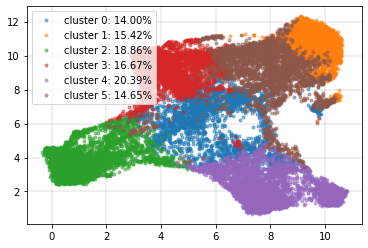

In [42]:
visualize(model)